## Wykład 5
---
+ Wykonanie współbieżne
+ Obliczenia równoległe
+ Operacje równoległe wysokopoziomowe
+ Dynamiczny scheduling
+ Komunikacja zdalna za pomocą kanałów
+ Tablice współdzielone
+ Menadżer klastra
+ Tablice rozproszone
+ zbiór Julii


## Wsparcie dla wykonania współbieżnego


https://docs.julialang.org/en/stable/manual/control-flow/#man-tasks-1

Zadania (tasks)  wykonuja zdefiniowaną procedurę. 

Jest to inny rodzaj przepływu kontroli - od trybu wykonania zwykłych instrukcji różnia sie tym, ze mogą zostać wiele razy  przerwane i wznowione = nie muszą wykonać się po kolei.

Za szeregowanie tasków (który kiedy się wykona itd.) odpowiedzialny jest Scheduler

Istnieją dwa rodzaje podejścia do przełączania tasków:

- <b>preemptive</b> - z wywłaszczeniem - scheduler sam decyduje kiedy przełączyć zadanie aby uzyskać płynną wielozadaniowość.
    - plusy: często bardziej wydajne, 
    - minusy: może prowadzić do wyścigów. np. wątki w Javie. 

- <b>cooperative</b>  - taski są przełączane tylko w dobrze zdefiniowanych punktach synchronizacyjnych. 
    - Minusy: jeśli taski nie wykorzystują tej możliwości właściwie, nie kooperują ze sobą, aby efektywnie wykorzystać procesor,  system może działać wolno. 
    - Plusy: nie trzeba martwić się o sytuacje wyścigu (łatwiejsza implementacja). 
    - Jest to rozwiązanie, które wybrano w Julii. 

inne nazwy dla tasków występujących w Julii: symmetric coroutines, lightweight threads, cooperative multitasking,  one-shot continuations.

Te możliwości nie oznaczają  automatycznie wykonania tasków na różnych węzłach / procesorach równolegle. 

Taski mogą przeplatać się w obrębie jednego węzła - mówimy wtedy o wykonaniu współbieżnym.

Jeśli używamy wielu węzłów/procesorów - wykonanie jest nie tylko współbieżne, ale i równoległe.


Kiedy stosuje się wielozadaniowość?

- Przy rozwiązywaniu pewnych problemów sposób z wywołaniem kolejnych  funkcji nie jest oczywisty.

- Przykładem jest problem producenta i konsumenta, w którym jedna złożona procedura generuje wiele wartości przez jakiś czas  i kolejna procedura ich używa. 

- Rozwiązanie polegające na tym,że konsument wywoła funkcję producenta nie jest wygodne, ponieważ producent może mieć więcej wartości do wygenerowania i trzeba wtedy czekać na zakończenie ich generacji, tymczasem konsument może  chcieć działać już na tych początkowych wartościach. Dlatego lepiej użyc mechanizmu przeplatającego.

- W Julii mamy dostępny typ Channel, który tworzy kanał komunikacyjny FIFO między zadaniami, które mogą do niego pisać 
(funkcja put!()) oraz czytać (funkcja take!())

- konstruktor dla typu  Channel przyjmuje jako argument funkcję jednoargumentową, która  definiuje   zadanie związane z danym kanałem. Możemy następnie wielokrotnie pobierać wartości z takiego kanału.



In [1]:
function producer(c::Channel)
           put!(c, "start")
           for n=1:4
               put!(c, 2n)
           end
           put!(c, "stop")
end;

In [2]:
 chnl = Channel(producer);

In [3]:
take!(chnl)

"start"

In [4]:
take!(chnl)

2

In [5]:
take!(chnl)

4

In [6]:
take!(chnl)

6

In [7]:
take!(chnl)

8

In [8]:
take!(chnl)

"stop"

In [9]:
# można też użyć pętli do konsumowania kolejnych produkowanych wartości.
for x in Channel(producer)
           println(x)
       end

start
2
4
6
8
stop


Nie musimy jawnie zamykać kanału w producencie, ponieważ obiekt kanału jest zamykany automatycznie po zakończeniu zadania, z którym jest powiązany. Wiele kanałów można powiązać z zadaniem i na odwrót. 

In [10]:
# Zadnia można tworzyć wprost używając konstruktora typu Task()
# konstruktor Task ten przyjmuje funkcję bezargumentową,  
# można to obejść używająć funkcji anonimowej

function mytask(myarg)
    det(rand(myarg, myarg))
end

taskHdl = Task(() -> mytask(100))






Task (runnable) @0x00007fd437c49270

 albo użyć makra (robi to samo, tylko wygodniej):
```julia
taskHdl = @task mytask(100)
```

In [11]:
# task został zdefiniowany, ale nie uruchomiony
istaskstarted(taskHdl)

false

In [12]:
# podajemy zadanie do kolejki schedulera
schedule(taskHdl);

In [13]:
#sprawdzamy, czy się zakończyło
istaskdone(taskHdl)

true

In [14]:
show(taskHdl)

Task (done) @0x00007fd437c49270

Więcej o możliwych funkcjach wykonywanych na taskach (podłączanie do kanałów, uzyskiwanie informacji, który task jest uruchomiony, możliwości niskopoziomowego przełączania się itd.):

https://docs.julialang.org/en/stable/stdlib/parallel/#tasks

In [15]:
# typ Task zawiera wiele informacji
fieldnames(taskHdl)

9-element Array{Symbol,1}:
 :parent    
 :storage   
 :state     
 :consumers 
 :donenotify
 :result    
 :exception 
 :backtrace 
 :code      

In [16]:
# stan tasku:

taskHdl.state

:done

In [17]:
#wynik
taskHdl.result

-4.20992460757163e25

Inne stany:
https://docs.julialang.org/en/stable/manual/control-flow/#task-states-1

Makro @async opakowuje wyrażenie jako Task i dodaje do kolejki  schedulara na <b> lokalnej</b> maszynie.
Macro @sync czeka na zakończenie się wszystkich zadań wywołanych przez @async

In [18]:
# bez wywołania funkcji yield() producent wrzuca produkty po kolei, nie przełącza się,  potem konsument je odbiera
# funkja yield wymusza przeplatane wykonanie.
println("--->")

function producent(c::Channel)
  
      println("+ producent zaczyna")
           for n=1:4
               produkt=string("produkt ", n)
               println("wkladam ", produkt)
               put!(c, produkt)
               #yield()
      
           end
    # tutaj musimy zamknąc kanał, inaczej konsument będzie "wisiał" na pętli for dla kanału z którym jest powiązany
      close(c)
      println("+ producent kończy")
   
end

function konsument(c::Channel)
    println("* konsument zaczyna")
    
    for produkt in c
           println("odebralem", produkt)
           #yield()
    end
   
    println("* konsument kończy")
end



@sync begin
    c=Channel(32)
 
    @async konsument(c)
    @async producent(c)
end

println("<---")

--->
* konsument zaczyna
+ producent zaczyna
wkladam produkt 1
wkladam produkt 2
wkladam produkt 3
wkladam produkt 4
+ producent kończy
odebralemprodukt 1
odebralemprodukt 2
odebralemprodukt 3
odebralemprodukt 4
* konsument kończy
<---


In [1]:
# sleep() powoduje zablokowanie tasku, scheduler przełącza na inny, aktywny task. 
for i in 1:3
    @async begin
        print("Zadanie $i\n ")
        sleep(rand()*0.1)
        print(" ($i) etap 1\n ")
        sleep(rand()*0.1)
        print(" ($i) etap 2\n")
        sleep(rand()*0.1)
    end
end
print("Główne zadanie\n")

Główne zadanie
Zadanie 1
 Zadanie 2
 Zadanie 3
  (2) etap 1
  (3) etap 1
  (1) etap 1
  (2) etap 2
 (3) etap 2
 (1) etap 2


In [20]:
# jeden ze sposobów wymuszenia kolejności - użycie ReentrantLock do synchronizacji
l = ReentrantLock()
@sync for i in 1:3
    @async begin
        lock(l)
        try
            print("Zadanie $i\n")
            sleep(rand()*0.2)
            print("($i) etap 1 \n")
            sleep(rand()*0.2)
            print("($i) etap 2\n")
        finally
            unlock(l)
        end
    end
end
print("Główne zadanie\n")

Zadanie 1
 (2) etap 1
  (3) etap 1
  (1) etap 1
  (2) etap 2
 (3) etap 2
 (1) etap 2
(1) etap 1 
(1) etap 2
Zadanie 2
(2) etap 1 
(2) etap 2
Zadanie 3
(3) etap 1 
(3) etap 2
Główne zadanie


## Wykonywanie równoległe

https://docs.julialang.org/en/stable/stdlib/parallel/

- Architektura master - worker.
- master - proces, z którego sterujemy wykonaniem programu
- master zleca wykonanie danej funkcji na innym procesie i ściąga wynik

In [3]:
# Uruchomienie procesów workerów (zwykle podajemy tyle, ile węzłów chcemy wykorzystać)
# jesli uruchamiamy konsole julii to można też użyć opcji 
# julia -p ilosc_workerów
# do usuwania workerów służy  rmprocs() - tylko dla procesu master !
if nprocs() == 1
    addprocs(3)
end
# wszystkie procesy
nprocs() |> println
# procesy workerów
# tablica identyfikatorów
workers() |> println
# ilość
nworkers()|> println

4
[2, 3, 4]
3


In [22]:
# każdy proces ( w tym główny) ma swój identyfikator
myid()

1

In [23]:
# pierwszy worker
workers()[1]

2

In [24]:
# uruchom funkcje na wybranym workerze, zwraca future
# future = "pudełko" na wynik, które wypełni się, jak wynik będzie gotowy
# argumenty:
# 1. funkcja jaka się ma wykonać
# 2. identyfikator workera, 
# 3. parametry funkcji
ref = remotecall(myid,workers()[1])

Future(2, 1, 5, Nullable{Any}())

In [25]:
# czekamy na wynik i wypełniamy pudełko
_id = fetch(ref)
println(_id)

2


In [26]:
tic()
ref = remotecall(x->(sleep(x);10x), workers()[1], 2)
toc()
tic()
fetch(ref) |> println
toc();

elapsed time: 0.590303957 seconds
20
elapsed time: 2.202733448 seconds


In [27]:
# przekazywanie RemoteRef między procesami
# makro @spawnat oblicza na workerze, którego identyfikator jest podany w pierwszym argumencie
# wyrażenie podane w  drugim argumencie 
# makro - wygodniejsze w użyciu niż funkcja


r = remotecall(()->rand(2,2),2)
s = @spawnat 3 fetch(r)+1
fetch(s)

2×2 Array{Float64,2}:
 1.9505   1.82577
 1.35591  1.49358

In [28]:
# makro @spawn wybiera zdalny proces. Druga linijka wykona się na tym samym procesie co pierwsza, 
# aby nie trzeba było przesyłać danych
# można definiować własne makra typu @spawn
# raz ściągnięty wynik future jest przechowywany lokalnie (cache), wartość przechowywana zdalnie jest kasowana.
r = @spawn rand(2,2)
s = @spawn 1 .+ fetch(r)
fetch(s)

2×2 Array{Float64,2}:
 1.67392  1.31254
 1.161    1.28014

In [29]:
# Jeśli operujemy na dużych danych warto zadbać, aby ich niepotrzebnie nie przesyłać.

# tutaj dane (wygenerowana tablica) są przesyłane z procesu 1 do procesu zdalnego
A = rand(1000,1000)
Bref = @spawn A^2
fetch(Bref)

# tutaj tablica generuje się już "na miejscu"
Bref = @spawn rand(1000,1000)^2
fetch(Bref);

In [30]:
# Co, jeśli zdefiniujemy własne funkcje, czy będą widoczne na pozostałych procesach?
function rand2(dims...)
    return 2*rand(dims...)
end

rand2 (generic function with 1 method)

In [31]:
rand2(2,2)

2×2 Array{Float64,2}:
 0.428524  0.937599
 1.819     0.24862 

In [32]:
#Proces nr 1 to master - wie o zdefiniowanej funkcji
r1 = @spawnat 1 rand2(2,2)
fetch(r1)

2×2 Array{Float64,2}:
 1.42743   1.79152
 0.522247  1.86269

In [33]:
# Proces nr 2 nie wie nic o nowo zdefiniowanej funkcji
r2 = @spawnat 2 rand2(2,2)
fetch(r2)

LoadError: [91mOn worker 2:
[91mUndefVarError: #rand2 not defined[39m
deserialize_datatype at ./serialize.jl:973
handle_deserialize at ./serialize.jl:677
deserialize at ./serialize.jl:637
handle_deserialize at ./serialize.jl:684
deserialize_global_from_main at ./distributed/clusterserialize.jl:154
foreach at ./abstractarray.jl:1733
deserialize at ./distributed/clusterserialize.jl:56
handle_deserialize at ./serialize.jl:726
deserialize at ./serialize.jl:637
handle_deserialize at ./serialize.jl:681
deserialize at ./serialize.jl:637
handle_deserialize at ./serialize.jl:684
deserialize_msg at ./distributed/messages.jl:98
message_handler_loop at ./distributed/process_messages.jl:161
process_tcp_streams at ./distributed/process_messages.jl:118
#99 at ./event.jl:73[39m

In [34]:
# makro everywhere uruchamia kod na wszystkich procesach, 
# może być użyte do zdefioniowania funkcji wszędzie
@everywhere function idtable(dims...)
    return myid()*ones(dims...)
end

In [35]:
r1 = @spawnat 3 idtable(2,2)
fetch(r1)

2×2 Array{Float64,2}:
 3.0  3.0
 3.0  3.0

In [36]:
A2=10000

10000

In [37]:
# ta funkcja to efektywne połączenie remote_call() i fetch() w jednym.
# A2 jest brane z otoczenia funcji remotecall_fetch, czyli procesu 1, 
# po wykonaniu A2 nadal istnieje w pamięci zdalnego workera workers()[2]
remotecall_fetch(()->A2,workers()[2])

10000

+ Jeśli globalna zmienna jest  używana w funkcji wywoływanej zdalnie na danym workerze, to zmienna ta jest automatycznie tworzona na tym workerze.

+ Stałe globalne są również zadeklarowane jako stałe na zdalnych workerach.

+ Zmienne globalne są  wysyłane poprzez wywołanie zdalne, przy kolejnych wywołaniach są wywyłane wtedy, gdy zmieniła się ich  wartość. Nie ma synchronizacji globalnych zmiennych między węzłami. Przykład:

In [38]:
A = 10
remotecall_fetch(()->A, 2) # worker 2
A = 20
remotecall_fetch(()->A, 3) # worker 3
A = 0

0

In [39]:
@everywhere function getA()
    A
end
remotecall_fetch(getA, 3)

20

In [40]:
remotecall_fetch(getA, 2)

10

In [41]:
getA()

0

In [4]:
# let wprowadza lokalny zakres, a co za tym idzie C nie będzie automatycznie zdefiniowana w workerze 2
A = 1;
remotecall_fetch(()->A, 2);
C = 3;
let C = C
           remotecall_fetch(()->C, 2)
end;
# whos() - funkcja informująca o globalnych zmiennych
@spawnat 2 whos();

	From worker 2:	                             A      8 bytes  Int64
	From worker 2:	                          Base               Module
	From worker 2:	                          Core               Module
	From worker 2:	                          Main               Module


### Operacje równoległe wysokopoziomowe

In [5]:
# każda operacja I^100 wykonywana jest równolegle (map) - master nie bierze udziału w obliczeniach
# wyniki wszystkich operacji równoległych są sumowane (reduce) - wykonywana w procesie wywołującym 

@parallel (+) for i=1:1000 
        BigInt(i)^100

end

10409322085141927639670203491499689537738780837791755480023910122413796284563817273031715389609548981241768473547819207141766480065813697534743324177871972318309449519400285796191029154173386427179568557187635957090705352571527670654111047109630289487169691389452699579236618703725748994463357307313300

In [6]:
# tutaj każdy proces ma swoją kopię tablicy a, więć kod nie zadziała dobrze
# @sync - czekamy na zakończenie się wszystkich obliczeń.
# master nie bierze udziału w obliczeniach.
a = zeros(10)
@sync @parallel for i=1:10
  a[i] = i
end
a


10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [45]:
# tutaj tablica jest współdzielona (SharedArray), każdy proces modyfikuje jej kawałek.

a1=SharedArray(Float64,10)
@sync @parallel for i=1:10
  a1[i] = i
end
a1



10-element SharedArray{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [46]:
a2=SharedArray(Int8,10)
@sync @parallel for i=1:10
  a2[i] = myid()
end
a2

10-element SharedArray{Int8,1}:
 3
 3
 3
 3
 4
 4
 4
 2
 2
 2

In [47]:
# pmap - działa podobnie jak @parallel for bez redukcji, ale jest wydajniejsza dla dłużej trwających operacji.

lst = collect(1:10)

pmap(x->myid(),lst)


10-element Array{Int64,1}:
 2
 3
 4
 2
 3
 2
 3
 2
 3
 2

### Dynamiczny scheduling w funkcji pmap

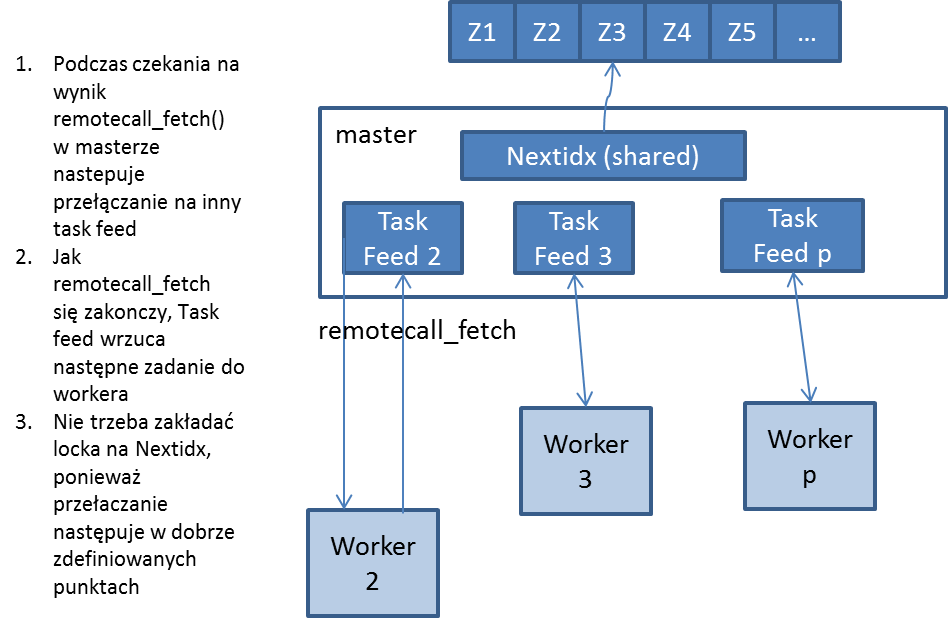

In [48]:
using Images
using FileIO
img = load("workerzy.png")

In [49]:
function pmap2(f, lst)
    np = nprocs()  # ile procesów ?
    n = length(lst)
    results = Vector{Any}(n)
    i = 1
    # indeks nastepnego zadania do zrobienia
    nextidx() = (idx=i; i+=1; idx)
    @sync begin
        for p=1:np
            if p != myid() || np == 1
                # tworzenie lokalnych tasków feed
                # żaden nie zacznie działać dopóki wszystkie nie zostaną utworzone i task główny nie wyjdzie 
                # z pętli @sync, gdzie będzie czekał na ich zakończenie
                @async begin
                    while true
                        idx = nextidx()
                        if idx > n
                            break
                        end
                        results[idx] = remotecall_fetch(f, p, lst[idx])
                    end
                end
            end
        end
    end
    results
end
#przykładowe użycie
M = Matrix{Float64}[rand(800,800), rand(600,600), rand(800,800), rand(600,600)]
pmap2(svd, M);

### Zdalne kanały komunikacji pomiędzy zadaniami na różnych workerach (Remote Channels)

In [50]:
# zdalny kanał przekazujący numery zadań
const jobs = RemoteChannel(()->Channel{Int}(32));

In [51]:
# zdalny kanał przekazujący wyniki
const results = RemoteChannel(()->Channel{Tuple}(32));

In [52]:
# funkcja wykonująca pewną (symulowaną sleepem) "pracę"
@everywhere function do_work(jobs, results) 
           while true
               job_id = take!(jobs)
               exec_time = rand()
               sleep(exec_time) # symulacja "pracy"
               put!(results, (job_id, exec_time, myid()))
           end
       end

In [53]:
# funkcja wkładająca  do kanału numery "prac"
function make_jobs(n)
           for i in 1:n
               put!(jobs, i)
           end
end;

In [54]:
n = 12;

In [55]:
@schedule make_jobs(n);

In [56]:
# startujemy zdalne zadania
# remote_do() - funkcja podobna do remote_call(), ale nie ma mozliwości ściągnięcia wyniku poprzez fetch()
for p in workers() 
           @async remote_do(do_work, p, jobs, results)
end


In [57]:
# wypisujemy wyniki
@elapsed while n > 0 
           job_id, exec_time, where = take!(results)
           println("$job_id finished in $(round(exec_time,2)) seconds on worker $where")
           n = n - 1
       end

1 finished in 0.22 seconds on worker 2
3 finished in 0.31 seconds on worker 3
2 finished in 0.46 seconds on worker 4
4 finished in 0.24 seconds on worker 2
6 finished in 0.31 seconds on worker 4
5 finished in 0.5 seconds on worker 3
7 finished in 0.52 seconds on worker 2
9 finished in 0.35 seconds on worker 3
8 finished in 0.53 seconds on worker 4
10 finished in 0.48 seconds on worker 2
11 finished in 0.8 seconds on worker 3
12 finished in 0.95 seconds on worker 4


4.22546639

## Tablice współdzielone
- Pozwalają na współdzielenie jednej tablicy pomiędzy wieloma procesami wykonywanymi na jednej maszynie ze wspólną pamięcią.
- Każdy z procesów ma dostęp do każdej części tablicy.

In [58]:
# utworzenie tablicy współdzielonej
S = SharedArray{Int,2}((3,3))

3×3 SharedArray{Int64,2}:
 0  0  0
 0  0  0
 0  0  0

In [59]:
S[3,2] = 7
S

3×3 SharedArray{Int64,2}:
 0  0  0
 0  0  0
 0  7  0

In [60]:
# worker 2 ustawia w tablicy S wartosc 2 w miejscu (1,1) 
remotecall_fetch(setindex!,2,S,2,1,1)

3×3 Array{Int64,2}:
 2  0  0
 0  0  0
 0  7  0

In [61]:
# efekt widac w masterze
S

3×3 SharedArray{Int64,2}:
 2  0  0
 0  0  0
 0  7  0

In [62]:
# localindexes() - podaje sugerwany logiczny podział tablicy współdzielonej (pomocny, gdy nie chcemy, aby workerzy sobie 
# nadpisywali zawartości tablicy, oczywiście jest to podział umowny, który można zmienić
for p in workers()
    println(remotecall_fetch(localindexes,p,S))
end

1:3
4:6
7:9


In [63]:
S = SharedArray{Int,2}((3,3), init = S -> S[Base.localindexes(S)] = myid())

3×3 SharedArray{Int64,2}:
 2  3  4
 2  3  4
 2  3  4

In [64]:
#Wector procesów uzywających  SharedArray
procs(S)

3-element Array{Int64,1}:
 2
 3
 4

In [65]:
# indexpids() - kazdy worker współdzielący tablice ma swój indeks (numerowane od 1..ilość workerów) 
for p in workers()
    println(remotecall_fetch(indexpids,p,S))
end

1
2
3


In [66]:
# dygresja: wypelnianie tablicy co 4 elementy (idziemy po kolumnach)
A=zeros(10,10)
A[1:4:length(A)]=1
A

10×10 Array{Float64,2}:
 1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [67]:
# można dzielić tablicę inaczej 
#tutaj cyklicznie od swojego indeksu co ilość workerów aż do długości tablicy
S = SharedArray{Int,2}((3,3), init = S -> S[indexpids(S):length(procs(S)):length(S)] = myid())

3×3 SharedArray{Int64,2}:
 2  2  2
 3  3  3
 4  4  4

In [68]:
# zwraca dane w SharedArray jako Array
sdata(S)

3×3 Array{Int64,2}:
 2  2  2
 3  3  3
 4  4  4

In [69]:
# jeśli nie zadbamy o logiczny podział, to wynik może być niedeterministyczny 
# np. każdy worker wypełnia  całą tablicę swoim identyfikatorem
# wynik jest niedeterministyczny - zależy od kolejności w jakiej workerzy wypełniają tę tablicę 
@sync begin
    for p in procs(S)
        @async begin
            remotecall_wait(fill!, p, S, p)
        end
    end
end
S

3×3 SharedArray{Int64,2}:
 3  2  3
 3  2  3
 3  2  3

In [70]:
# pomocniczo: tworzy linspace 5-ciu równoodległych elementów od 0 do 10
linspace(0,10,5)

0.0:2.5:10.0

In [71]:
# pomocniczo: zaokrąglanie
round(Int, 4.51)

5

In [72]:
 # pomocniczo: tworzy linspace 5-ciu równoodległych elementów od 0 do 10 i zaokrągla
[round(Int, s) for s in linspace(0,10,5)]

5-element Array{Int64,1}:
  0
  2
  5
  8
 10

In [73]:
# żeby mieć wpływ na to, który worker działa na którym elemencie tablicy 
# możemy stworzyć ręczny podział tablicy
# każdy worker wylicza, który kawałek tablicy dostanie
@everywhere function myrange(q::SharedArray)
    idx = indexpids(q)
    if idx == 0
        # master nie dostaje kawałka 
        return 1:0, 1:0
    end
    # na ile mamy podzielić?
    nchunks = length(procs(q))
    
    # wyliczamy granice podziałów
    splits = [round(Int, s) for s in linspace(0,size(q,2),nchunks+1)]
    # zwracamy granice podziałów w odpowiednim formacie
    1:size(q,1), splits[idx]+1:splits[idx+1]
end

# kernel obliczeniowy 
@everywhere function advection_chunk!(q, u, irange, jrange, trange)
    @show (irange, jrange, trange)  # wyświetlanie
    for t in trange, j in jrange, i in irange
        q[i,j,t+1] = q[i,j,t] +  u[i,j,t]
    end
    q
end

#  definiujemy obliczenie kernela z wyliczonym podziałem przez funkcje myrange()
@everywhere advection_shared_chunk!(q, u) = advection_chunk!(q, u, myrange(q)..., 1:size(q,3)-1)


In [74]:
# wersja 1: wywołanie funkcji wg wyliczonego podziału na wielu workerach.
function advection_shared!(q, u)
    @sync begin
        for p in procs(q)
            @async remotecall_wait(advection_shared_chunk!, p, q, u)
        end
    end
    q
end


advection_shared! (generic function with 1 method)

In [75]:
# wersja 2: sekwencyjne obliczanie
advection_serial!(q, u) = advection_chunk!(q, u, 1:size(q,1), 1:size(q,2), 1:size(q,3)-1)


advection_serial! (generic function with 1 method)

In [76]:
#  wersja 3: nie korzysta z ręcznego podziału, tylko z makra @parallel działającego drobnoziarniście 
# wzdłuż drugiej współrzędnej
function advection_parallel!(q, u)
    for t = 1:size(q,3)-1
        @sync @parallel for j = 1:size(q,2)
            for i = 1:size(q,1)
                q[i,j,t+1]= q[i,j,t] + u[i,j,t]
            end
        end
    end
    q
end


advection_parallel! (generic function with 1 method)

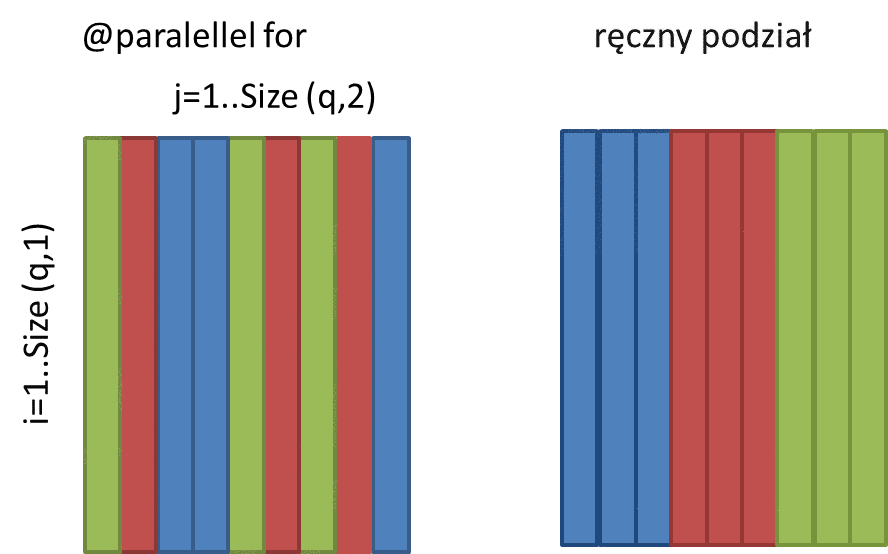

In [77]:
using Images
using FileIO
img = load("shared_arrays.png")

In [78]:
q = SharedArray(Float64, (100,100,100))
u = SharedArray(Float64, (100,100,100))

# Uruchamiamy do celów kompilacji
advection_serial!(q, u)
advection_parallel!(q, u)
advection_shared!(q,u);



(irange, jrange, trange) = (1:100, 1:100, 1:99)
	From worker 3:	(irange, jrange, trange) = (1:100, 34:67, 1:99)
	From worker 2:	(irange, jrange, trange) = (1:100, 1:33, 1:99)
	From worker 4:	(irange, jrange, trange) = (1:100, 68:100, 1:99)


In [79]:
@time advection_serial!(q, u);

(irange, jrange, trange) = (1:100, 1:100, 1:99)
  0.012273 seconds (156 allocations: 5.359 KiB)


In [80]:
@time advection_shared!(q,u);

	From worker 2:	(irange, jrange, trange) = (1:100, 1:33, 1:99)
	From worker 3:	(irange, jrange, trange) = (1:100, 34:67, 1:99)
	From worker 4:	(irange, jrange, trange) = (1:100, 68:100, 1:99)
  0.005609 seconds (756 allocations: 44.078 KiB)


In [81]:
@time advection_parallel!(q, u);

  0.405066 seconds (69.73 k allocations: 2.912 MiB)


### Menadżer klastra

Uruchomienie, zarządzanie i łączenie procesów Julii w logiczny klaster odbywa się za pośrednictwem menedżerów klastrów. ClusterManager odpowiedzialny jest za

- uruchamianie procesów roboczych (workerów)
- zarządzanie zdarzeniami w trakcie życia workerów
- transport danych (opcjonalnie)

Klaster Julii ma następujące cechy:

-   proces nadrzędny (master) ma identyfikator równy 1.
-   tylko proces nadrzędny może dodawać lub usuwać workerów.
-   wszystkie procesy mogą się komunikować ze sobą nawzajem.

Połączenia między workerami (przy użyciu wbudowanego transportu TCP / IP) są ustalane w następujący sposób:

 - Addprocs() jest wywoływany w procesie nadrzędnym 
 - Addprocs() wywołuje odpowiednią metodę launch(), która uruchamia wymaganą liczbę procesów roboczych na odpowiednich maszynach
 - Każdy worker zaczyna słuchać na wolnym porcie i wypisuje informacje o hostach i portach na STDOUT
 - Menedżer klastrów przechwytuje STDOUT workerów i udostępnia je do procesu nadrzędnego
 - Master  nawiązuje połączenia TCP / IP z każdym workerem
 - Każdy worker jest również informowany o innych workerach
 - Każdy worker łączy się ze wszystkimi workerami, których identyfikator jest mniejszy niż identyfikator danego workera
    W ten sposób powstaje sieć powiązań, w której każdy worker jest bezpośrednio związany z każdym innym workerem



Julia oferuje dwóch wbudowanych menedżerów klastrów:

    - LocalManager  - do uruchamiania dodatkowych workerów na tym samym hoście, wykorzystując wiele rdzeni (Użycie addprocs() lub addprocs(np :: Integer))
    - SSHManager -do uruchamiania dodatkowych workerów na zdalnych hotach dostępnych przez SSH,(użycie addprocs (hostnames :: Array) -  lista nazw hostów)



## Tablice rozproszone
- Każdy proces ma dostęp do swojej części tablicy.
- Pozwalają na wykorzystanie pamięci wielu węzłów.
- przydatne w środowisku rozproszonym, gdzie węzły nie mają pamięci wspólnej
```julia
Pkg.add("DistributedArrays")
```

In [82]:
# @everywhere - wykonuje sie na kazdym procesie
@everywhere using DistributedArrays

In [83]:
#tworzymy tablicę rozproszona pomiędzy workery 
DA1 = @DArray [(i, j) for i = 1:5, j = 1:5]

5×5 DistributedArrays.DArray{Tuple{Int64,Int64},2,Array{Tuple{Int64,Int64},2}}:
 (1, 1)  (1, 2)  (1, 3)  (1, 4)  (1, 5)
 (2, 1)  (2, 2)  (2, 3)  (2, 4)  (2, 5)
 (3, 1)  (3, 2)  (3, 3)  (3, 4)  (3, 5)
 (4, 1)  (4, 2)  (4, 3)  (4, 4)  (4, 5)
 (5, 1)  (5, 2)  (5, 3)  (5, 4)  (5, 5)

In [84]:
# localindexes - funkcja pokazujaca jaki zakres indeksów obejmuje dany worker
#funkcja remotecall() zwraca future, które później jest użyte do ściągnięcia wyniku w funkcji fetch() 
refs = [remotecall(localindexes,w,DA1) for w in workers()]
for r in refs
     d = fetch(r)
     println(d)
end

(1:5, 1:2)
(1:5, 3:3)
(1:5, 4:5)


In [85]:
# localpart - jaka część tablicy przyporządkowana jest danemu workerowi
refs = [remotecall(localpart,w,DA1) for w in workers()]
for r in refs
     d = fetch(r)
     print("----------\n")
     println(d)
end

----------
Tuple{Int64,Int64}[(1, 1) (1, 2); (2, 1) (2, 2); (3, 1) (3, 2); (4, 1) (4, 2); (5, 1) (5, 2)]
----------
Tuple{Int64,Int64}[(1, 3); (2, 3); (3, 3); (4, 3); (5, 3)]
----------
Tuple{Int64,Int64}[(1, 4) (1, 5); (2, 4) (2, 5); (3, 4) (3, 5); (4, 4) (4, 5); (5, 4) (5, 5)]


In [86]:
#przykład przetwarzania tablicy rozproszonej
@everywhere function processingExample(d::DArray)
        println(size(d), " ", procs(d))
         # konstruktor tablicy rozproszonej, podajemy całkowity rozmiar, listę procesów oraz blok do...end inicjalizujacy 
         # tablicę
        DArray(size(d),procs(d)) do I
          println("mój zakres ", I)
          fill( myid(),(length(I[1]), length(I[2])))
        end
end

In [87]:
processingExample(DA1)

(5, 5) [2 3 4]
	From worker 2:	mój zakres (1:5, 1:2)
	From worker 3:	mój zakres (1:5, 3:3)
	From worker 4:	mój zakres (1:5, 4:5)


5×5 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
 2  2  3  4  4
 2  2  3  4  4
 2  2  3  4  4
 2  2  3  4  4
 2  2  3  4  4

### Przykład -  Gra w życie
https://pl.wikipedia.org/wiki/Gra_w_%C5%BCycie

In [88]:
# Przykład komunikacji z najbliższymi sąsiadami -  gra w życie
#Sciaganie danych od sąsiadów jest realizowane przez kopiowanie danych wg odpowiednich indeksów

@everywhere function life_step(d::DArray)
        println(size(d), " ", procs(d))
         # konstruktor tablicy rozproszonej, podajemy całkowity rozmiar, listę procesów oraz blok do...end inicjalizujacy 
         # tablicę
        DArray(size(d),procs(d)) do I
        
            # granice powiększone o brzegi sąsiadów
            top   = mod(first(I[1])-2,size(d,1))+1
            bot   = mod( last(I[1])  ,size(d,1))+1
            left  = mod(first(I[2])-2,size(d,2))+1
            right = mod( last(I[2])  ,size(d,2))+1
            println("Mój zakres ", I, " mój zakres + sąsiadujące brzegi ", " bot=", bot, " top=",top," left=", left, " right=",right) 
           
           
            # lokalna tablica , do której ściagane są dane od sąsiadów
            old = Array{Int64}(length(I[1])+2, length(I[2])+2)
     
            old[1      , 1      ] = d[top , left]   # left side
            old[2:end-1, 1      ] = d[I[1], left]
            old[end    , 1      ] = d[bot , left]
            old[1      , 2:end-1] = d[top , I[2]]
            old[2:end-1, 2:end-1] = d[I[1], I[2]]   # middle
            old[end    , 2:end-1] = d[bot , I[2]]
            old[1      , end    ] = d[top , right]  # right side
            old[2:end-1, end    ] = d[I[1], right]
            old[end    , end    ] = d[bot , right]
          
            # zwracana tablica new to wynik przetworzenia (lokalnie) naszej części tablicy, z której skomponowana zostanie wyjściowa
            # tablica rozproszona
            new=life_rule(old)
         
         
        end
    end

In [89]:
# reguła gry w życie (uruchamiana na lokalnych danych)
@everywhere function life_rule(old)
        m, n = size(old)
        new = similar(old, m-2, n-2)
        for j = 2:n-1
            for i = 2:m-1
                nc = +(old[i-1,j-1], old[i-1,j], old[i-1,j+1],
                       old[i  ,j-1],             old[i  ,j+1],
                       old[i+1,j-1], old[i+1,j], old[i+1,j+1])
                new[i-1,j-1] = (nc == 3 || nc == 2 && old[i,j])
            end
        end
        new
    end

In [90]:
# przykładowa tablica wejściowa
DA = @DArray [((i+j)%2) for i = 1:15, j = 1:15]

15×15 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
 0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 1  0  1  0  1  0  1  0  1  0  1  0  1  0  1
 0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 1  0  1  0  1  0  1  0  1  0  1  0  1  0  1
 0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 1  0  1  0  1  0  1  0  1  0  1  0  1  0  1
 0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 1  0  1  0  1  0  1  0  1  0  1  0  1  0  1
 0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 1  0  1  0  1  0  1  0  1  0  1  0  1  0  1
 0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 1  0  1  0  1  0  1  0  1  0  1  0  1  0  1
 0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 1  0  1  0  1  0  1  0  1  0  1  0  1  0  1
 0  1  0  1  0  1  0  1  0  1  0  1  0  1  0

In [91]:
# krok gry w życie
life_step(DA)

(15, 15) [2 3 4]
	From worker 4:	Mój zakres (1:15, 11:15) mój zakres + sąsiadujące brzegi  bot=1 top=15 left=10 right=1
	From worker 3:	Mój zakres (1:15, 6:10) mój zakres + sąsiadujące brzegi  bot=1 top=15 left=5 right=11
	From worker 2:	Mój zakres (1:15, 1:5) mój zakres + sąsiadujące brzegi  bot=1 top=15 left=15 right=6


15×15 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
 0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  1  0  1  0  1  0  1  0  1  0  1  0  1  0

### Zbiór Julii

-1.8019009504752377-0.8999499749874937
  2.207852 seconds (12.02 M allocations: 672.429 MiB, 9.76% gc time)


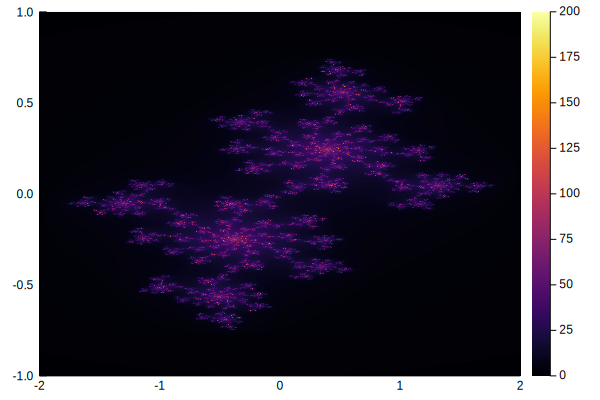

In [2]:
using Plots
Plots.gr()

# punkt o współrzędnych (x,y) należy do zbioru Julii o parametrze  c 
# jeśli dla liczby zespolonej z=x+i*y
# ciąg zₙ₊₁=zₙ²+c , nie dąży do nieskończoności

# dążenie do nieskończoności sprawdzamy ustawiająć maksymalną liczbę iteracji i sprawdzając
# czy kolejne wyrazy ciągu nie przekroczą zadanego progu (tutaj 2) w tej (bądź mniejszej)
# liczbie iteracji

# funkcja sprawdzająca, czy punkt z należy do zbioru Julii o parametrze c
function generate_julia(z; c=2, maxiter=200)
    for i=1:maxiter
        if abs(z) > 2
            return i-1
        end
        z = z^2 + c
    end
    maxiter
end

# obliczamy zbiór Julii na płaszczyźnie punktów od-do.

function calc_julia!(julia_set, xrange, yrange; maxiter=200, height=400, width_start=1, width_end=400)
   for x=width_start:width_end
        for y=1:height
            z = xrange[x] + 1im*yrange[y]
            julia_set[x, y] = generate_julia(z, c=-0.70176-0.3842im, maxiter=maxiter)
        end
    end
end

# główna funkcja 

function calc_julia_main(h,w)
  # ustawiamy płaszczyznę
    xmin, xmax = -2,2
   ymin, ymax = -1,1
   xrange = linspace(xmin, xmax, w)
   yrange = linspace(ymin, ymax, h)
	println(xrange[100],yrange[101])
   julia_set = Array(Int64, (w, h))
    
   # obliczamy
   @time calc_julia!(julia_set, xrange, yrange, height=h, width_end=w)
    
    # rysujemy
   pl=Plots.heatmap(xrange, yrange, julia_set)
   png("julia")
   return pl
end


calc_julia_main(2000,2000)

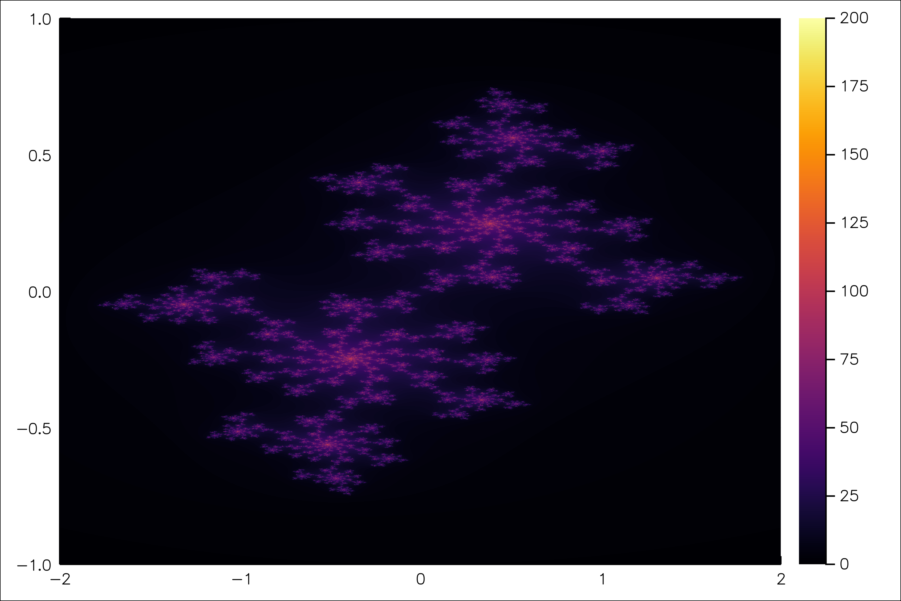

In [3]:
using Images
using FileIO
img = load("julia.png")